forked from:

https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast  
https://www.kaggle.com/jpison/inference-resnest50-fast-with-example-test-audio/


Thank you for sharing !

### import

In [1]:
import os
import gc
import time
import math
import shutil
import random
import warnings
import typing as tp
from pathlib import Path
from contextlib import contextmanager

import yaml
from joblib import delayed, Parallel

import cv2
import librosa
import audioread
import soundfile as sf

import numpy as np
import pandas as pd

from fastprogress import progress_bar
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair
import torch.utils.data as data

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### define utilities

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
#     torch.backends.cudnn.deterministic = True  # type: ignore
#     torch.backends.cudnn.benchmark = True  # type: ignore
    

@contextmanager
def timer(name: str) -> None:
    """Timer Util"""
    t0 = time.time()
    print("[{}] start".format(name))
    yield
    print("[{}] done in {:.0f} s".format(name, time.time() - t0))

In [3]:
# logger = get_logger("main.log")
set_seed(1213)

### read data

In [4]:
ROOT = Path.cwd().parent
INPUT_ROOT = ROOT / "input"
RAW_DATA = INPUT_ROOT / "birdsong-recognition"
TRAIN_AUDIO_DIR = RAW_DATA / "train_audio"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test_audio"

In [5]:
train = pd.read_csv(RAW_DATA / "train.csv")

In [6]:
if not TEST_AUDIO_DIR.exists():
    TEST_AUDIO_DIR = INPUT_ROOT / "birdcall-check" / "test_audio"
    test = pd.read_csv(INPUT_ROOT / "birdcall-check" / "test.csv")
else:
    test = pd.read_csv(RAW_DATA / "test.csv")

In [7]:
sub = pd.read_csv("../input/birdsong-recognition/sample_submission.csv")
sub.to_csv("submission.csv", index=False)  # this will be overwritten if everything goes well

### set parameters

In [8]:
TARGET_SR = 32000
model_config = {
    "base_model_name": "resnest50_fast_1s1x64d",
    "pretrained": False,
    "num_classes": 264,
    "trained_weights": "../input/training-birdsong-baseline-resnest50-fast/best_model.pth"
}

melspectrogram_parameters = {
    "n_mels": 128,
    "fmin": 20,
    "fmax": 14000
}

## Definition

### Dataset

For `site_3`, I decided to use the same procedure as I did for `site_1` and `site_2`, which is, crop 5 seconds out of the clip and provide prediction on that short clip.
The only difference is that I crop 5 seconds short clip from start to the end of the `site_3` clip and aggeregate predictions for each short clip after I did prediction for all those short clips.

In [9]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [10]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


class TestDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray,
                 img_size=224, melspectrogram_parameters={}):
        self.df = df
        self.clip = clip
        self.img_size = img_size
        self.melspectrogram_parameters = melspectrogram_parameters
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = 32000
        sample = self.df.loc[idx, :]
        site = sample.site
        row_id = sample.row_id
        
        if site == "site_3" or site == "example":
            y = self.clip.astype(np.float32)
            len_y = len(y)
            start = 0
            end = SR * 5
            images = []
            while len_y > start:
                y_batch = y[start:end].astype(np.float32)
                if len(y_batch) != (SR * 5):
                    break
                start = end
                end = end + SR * 5
                
                melspec = librosa.feature.melspectrogram(y_batch,
                                                         sr=SR,
                                                         **self.melspectrogram_parameters)
                melspec = librosa.power_to_db(melspec).astype(np.float32)
                image = mono_to_color(melspec)
                height, width, _ = image.shape
                image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
                image = np.moveaxis(image, 2, 0)
                image = (image / 255.0).astype(np.float32)
                images.append(image)
            images = np.asarray(images)
            return images, row_id, site
        else:
            end_seconds = int(sample.seconds)
            start_seconds = int(end_seconds - 5)
            
            start_index = SR * start_seconds
            end_index = SR * end_seconds
            
            y = self.clip[start_index:end_index].astype(np.float32)

            melspec = librosa.feature.melspectrogram(y, sr=SR, **self.melspectrogram_parameters)
            melspec = librosa.power_to_db(melspec).astype(np.float32)

            image = mono_to_color(melspec)
            height, width, _ = image.shape
            image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
            image = np.moveaxis(image, 2, 0)
            image = (image / 255.0).astype(np.float32)

            return image, row_id, site

### model

* I forked this code from authors' original implementation. [GitHub](https://github.com/zhanghang1989/ResNeSt)

In [11]:
class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm_layer=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm_layer is not None
        if self.use_bn:
            self.bn0 = norm_layer(channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = norm_layer(inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            if torch.__version__ < '1.5':
                splited = torch.split(x, int(rchannel//self.radix), dim=1)
            else:
                splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            if torch.__version__ < '1.5':
                attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            else:
                attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

In [12]:
class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

In [13]:
def get_model(args: tp.Dict):
    # # get resnest50_fast_1s1x64d
    model = ResNet(
        Bottleneck, [3, 4, 6, 3],
        radix=1, groups=1, bottleneck_width=64,
        deep_stem=True, stem_width=32, avg_down=True,
        avd=True, avd_first=True)
    
    del model.fc
    # # use the same head as the baseline notebook.
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, args["num_classes"]))
    
    state_dict = torch.load(args["trained_weights"])
    model.load_state_dict(state_dict)
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    return model

## Prediction loop

In [14]:
def prediction_for_clip(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model: ResNet, 
                        mel_params: dict, 
                        threshold=0.8):

    dataset = TestDataset(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in progress_bar(loader):
        site = site[0]
        row_id = row_id[0]
        
        if site in {"site_1", "site_2"}:
            image = image.to(device)

            with torch.no_grad():
                prediction = F.sigmoid(model(image))
                proba = prediction.detach().cpu().numpy().reshape(-1)

            events = proba >= threshold
            labels = np.argwhere(events).reshape(-1).tolist()
            
            if len(labels) == 0:
                prediction_dict[row_id] = "nocall"
            else:
                labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
                label_string = " ".join(labels_str_list)
                prediction_dict[row_id] = label_string
        
        if site in {"site_3"}:
            # to avoid prediction on large batch
            image = image.squeeze(0)
            print(image.shape)
            batch_size = 16
            whole_size = image.size(0)
            if whole_size % batch_size == 0:
                n_iter = whole_size // batch_size
            else:
                n_iter = whole_size // batch_size + 1
                
            all_events = set()
            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
                if batch.ndim == 3:
                    batch = batch.unsqueeze(0)

                batch = batch.to(device)
                with torch.no_grad():
                    prediction = F.sigmoid(model(batch))
                    proba = prediction.detach().cpu().numpy()
                    
                events = proba >= threshold
                for i in range(len(events)):
                    event = events[i, :]
                    labels = np.argwhere(event).reshape(-1).tolist()
                    for label in labels:
                        all_events.add(label)
                        
            labels = list(all_events)
            
            if len(labels) == 0:
                prediction_dict[row_id] = "nocall"
            else:
                labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
                label_string = " ".join(labels_str_list)
                prediction_dict[row_id] = label_string
        
        if site in {"example"}:
            nsec = 1
            image = image.squeeze(0)
            print(image.shape)
            batch_size = 16
            whole_size = image.size(0)
            if whole_size % batch_size == 0:
                n_iter = whole_size // batch_size
            else:
                n_iter = whole_size // batch_size + 1
            
            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
                if batch.ndim == 3:
                    batch = batch.unsqueeze(0)

                batch = batch.to(device)
                with torch.no_grad():
                    prediction = F.sigmoid(model(batch))
                    proba = prediction.detach().cpu().numpy()
                
                events = (proba >= threshold)
                for i in range(len(events)):
                    row_id_sec = row_id+'_'+str(int(nsec*5))
                    nsec += 1
                    event = events[i, :]
                    
                    all_events = set()
                    labels = np.argwhere(event).reshape(-1).tolist()
                    for label in labels:
                        all_events.add(label)
                    labels = list(all_events)
                    
                    if len(labels) == 0:
                        prediction_dict[row_id_sec] = "nocall"
                    else:
                        labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
                        label_string = " ".join(labels_str_list)
                        prediction_dict[row_id_sec] = label_string
    return prediction_dict

In [15]:
def prediction(test_df: pd.DataFrame,
               test_audio: Path,
               model_config: dict,
               mel_params: dict,
               target_sr: int,
               threshold=0.8):
    model = get_model(model_config)
    unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    for audio_id in unique_audio_id:
        with timer(f"Loading {audio_id}"):
            clip, _ = librosa.load(test_audio / (audio_id + ".mp3"),
                                   sr=target_sr,
                                   mono=True,
                                   res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        with timer(f"Prediction on {audio_id}"):
            prediction_dict = prediction_for_clip(test_df_for_audio_id,
                                                  clip=clip,
                                                  model=model,
                                                  mel_params=mel_params,
                                                  threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

## Check with 'example_test_audio' data

In [16]:
# if LOCAL:
test_sample = pd.read_csv("../input/birdsong-recognition/example_test_audio_summary.csv")
test_sample.head()
test2 = test_sample.copy()
test2['audio_id'] = test2['filename'].copy()
test2['site'] = 'example'
test2['row_id'] = test2['site'] + '_' + test2['audio_id'] + '_' + test2['seconds'].astype(str)
test2['seconds'] = test2['seconds'].astype(np.float32)
test2 = test2[['site','row_id','seconds','audio_id','birds']]

In [17]:
test_tosub = test2[['site','audio_id']].drop_duplicates()
test_tosub['row_id'] = test_tosub['site'] + '_' + test_tosub['audio_id'] 
test_tosub['seconds'] = np.nan
test_tosub = test_tosub[['site','row_id', 'seconds', 'audio_id']]

In [18]:
# Change audio_id to original values
test_tosub.iloc[0,3] = 'BLKFR-10-CPL_20190611_093000.pt540'
test_tosub.iloc[1,3] = 'ORANGE-7-CAP_20190606_093000.pt623'

## Prediction with different thresholds

In [19]:
test3 = test2.copy()
BIRD_CODE['nocall'] = 264
res = []
for thr in np.linspace(0.10,1.00,19):
    test2 = test3.copy()
    TEST_AUDIO_DIR2 = Path('../input/birdsong-recognition/example_test_audio/')
    submission_test = prediction(test_df=test_tosub,
                            test_audio=TEST_AUDIO_DIR2,
                            model_config=model_config,
                            mel_params=melspectrogram_parameters,
                            target_sr=TARGET_SR,
                            threshold=thr)
    submission_test.rename(columns={'birds': 'birds_pred'}, inplace=True)
    test2 = test2.merge(submission_test,how="left",on="row_id")
    test2['birds'] = test2['birds'].fillna("nocall")
    
    labels_hot = np.zeros((len(test2), 265), dtype=int)
    preds_hot = np.zeros((len(test2), 265), dtype=int)
    for nrow in range(len(labels_hot)):
        row = test2.iloc[nrow]
        for label in row['birds'].split(' '):
            if label in BIRD_CODE.keys():
                labels_hot[nrow,BIRD_CODE[label]] = 1
        # If there is no birds in train labels then nocall=1
        if labels_hot[nrow,:].sum()<1.0:
            labels_hot[nrow,BIRD_CODE["nocall"]] = 1
        for label in row['birds_pred'].split(' '):
            preds_hot[nrow,BIRD_CODE[label]] = 1

    f1score = f1_score(labels_hot,preds_hot,average='micro')
    res.append([thr, f1score])

[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 5 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 3 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 2 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 5 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s
[Loading BLKFR-10-CPL_20190611_093000.pt540] start
[Loading BLKFR-10-CPL_20190611_093000.pt540] done in 4 s
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] start


torch.Size([94, 3, 224, 547])
[Prediction on BLKFR-10-CPL_20190611_093000.pt540] done in 2 s
[Loading ORANGE-7-CAP_20190606_093000.pt623] start
[Loading ORANGE-7-CAP_20190606_093000.pt623] done in 3 s
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] start


torch.Size([61, 3, 224, 547])
[Prediction on ORANGE-7-CAP_20190606_093000.pt623] done in 1 s


In [20]:
res = pd.DataFrame(res,columns=['threshold','f1-score'])

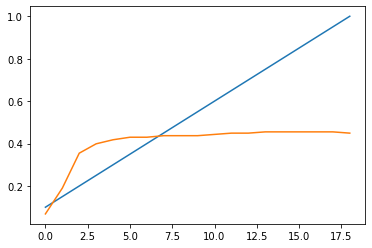

In [21]:
import matplotlib.pyplot as plt
plt.plot(res)

In [22]:
threshold = res['threshold'].values[res['f1-score'].argmax()]
threshold

0.75